In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
print sns.__version__
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self, ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit

3
0.7.0


In [2]:
# Set up console so we can reattach via terminal ipython later. See:
# https://stackoverflow.com/questions/19479645/using-ipython-console-along-side-ipython-notebook

%qtconsole

# Then do `ipython console --existing` in a terminal to connect and have access to same data!
# But note, do not do CTRL-D in that terminal or it will kill the kernel!

In [12]:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=False, skyLimited=True)
res = testObj.runTest(returnSources=True)
detectedSources = res['sources']
del res['sources']
print res

{'ZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack': {'FP': 2, 'FN': 25, 'TP': 25}, 'SZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack_decorr': {'FP': 5, 'FN': 25, 'TP': 25}}


Do forced phot. now with funcs in diffimTests:

In [5]:
cats = testObj.doForcedPhot(transientsOnly=True)

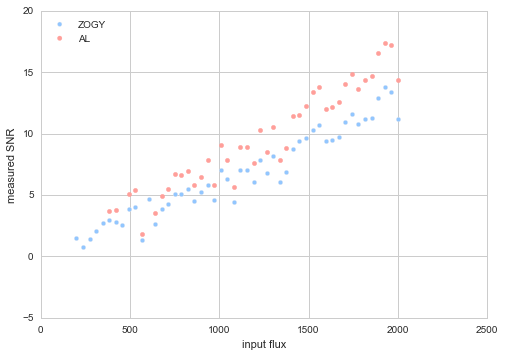

In [6]:
sources, _, _, mc1, mc2, _ = cats
plt.scatter(sources['inputFlux_science'], mc1['base_PsfFlux_flux']/mc1['base_PsfFlux_fluxSigma'], label='ZOGY')
plt.scatter(sources['inputFlux_science'], mc2['base_PsfFlux_flux']/mc2['base_PsfFlux_fluxSigma'], label='AL', color='r')
plt.legend(loc='upper left')
plt.xlabel('input flux')
plt.ylabel('measured SNR')

Figure out matching

In [11]:
import lsst.afw.table as afwTable

matches = afwTable.matchXy(mc1, mc2, 1.0)
print len(matches)
match = matches[0]
print match[0].getX(), match[1].getX()

50
389.757115114 389.757115114


In [14]:
ZOGY_detections = dit.doDetection(testObj.D_ZOGY.asAfwExposure(), asDF=False)

In [17]:
matches = afwTable.matchXy(ZOGY_detections, mc1, 1.0)
len(matches)

26